In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

load data


In [ ]:
matches_path="/content/matches.csv"
matches_df=pd.read_csv(matches_path)
print(matches_df.shape)

matches_df.head(5)
#data preparation
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df.head(5)

(1095, 20)


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [ ]:
#reshape and caluclate team metrics
team_performance=matches_df.melt(
    id_vars=["id","season","date","winner","result_margin","result","target_runs"],
    value_vars=["team1","team2"],
    var_name="home_away",
    value_name="team"
)
team_performance["is_winner"]=(team_performance["team"]==team_performance["winner"]).astype(int)
team_performance["runs_scored"]=team_performance["target_runs"]
team_performance["runs_conceded"]=team_performance.groupby("id")["target_runs"].transform("sum")-team_performance["target_runs"]
team_performance.head(5)

,id,season,date,winner,result_margin,result,target_runs,home_away,team,is_winner,runs_scored,runs_conceded
0,335982,2007/08,2008-04-18,Kolkata Knight Riders,140.0,runs,223.0,team1,Royal Challengers Bangalore,0,223.0,223.0
1,335983,2007/08,2008-04-19,Chennai Super Kings,33.0,runs,241.0,team1,Kings XI Punjab,0,241.0,241.0
2,335984,2007/08,2008-04-19,Delhi Daredevils,9.0,wickets,130.0,team1,Delhi Daredevils,1,130.0,130.0
3,335985,2007/08,2008-04-20,Royal Challengers Bangalore,5.0,wickets,166.0,team1,Mumbai Indians,0,166.0,166.0
4,335986,2007/08,2008-04-20,Kolkata Knight Riders,5.0,wickets,111.0,team1,Kolkata Knight Riders,1,111.0,111.0


In [ ]:
#aggreated data for each team
team_performance_agg =team_performance.groupby(["team" ,"date"]).agg({
    "is_winner":"sum",
    "runs_scored":"sum",
    "runs_conceded":"sum"
}).sort_values("date").reset_index()

team_performance_agg["net_run_rate"] =team_performance_agg["runs_scored"] - team_performance_agg["runs_conceded"]
team_performance_agg

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
0,Royal Challengers Bangalore,2008-04-18,0,223.0,223.0,0.0
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
2,Delhi Daredevils,2008-04-19,1,130.0,130.0,0.0
3,Rajasthan Royals,2008-04-19,0,130.0,130.0,0.0
4,Kings XI Punjab,2008-04-19,0,241.0,241.0,0.0
...,...,...,...,...,...,...
2185,Royal Challengers Bengaluru,2024-05-22,0,173.0,173.0,0.0
2186,Rajasthan Royals,2024-05-24,0,176.0,176.0,0.0
2187,Sunrisers Hyderabad,2024-05-24,1,176.0,176.0,0.0
2188,Kolkata Knight Riders,2024-05-26,1,114.0,114.0,0.0


In [ ]:
team_name = "Chennai Super Kings"
team_data = team_performance_agg[team_performance_agg["team"] ==team_name]
team_data

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
5,Chennai Super Kings,2008-04-19,1,241.0,241.0,0.0
15,Chennai Super Kings,2008-04-23,1,209.0,209.0,0.0
20,Chennai Super Kings,2008-04-26,1,148.0,148.0,0.0
29,Chennai Super Kings,2008-04-28,1,179.0,179.0,0.0
39,Chennai Super Kings,2008-05-02,0,170.0,170.0,0.0
...,...,...,...,...,...,...
2145,Chennai Super Kings,2024-05-01,0,163.0,163.0,0.0
2153,Chennai Super Kings,2024-05-05,1,168.0,168.0,0.0
2164,Chennai Super Kings,2024-05-10,0,232.0,232.0,0.0
2168,Chennai Super Kings,2024-05-12,1,142.0,142.0,0.0


In [ ]:
team_data = team_data.sort_values("date")

team_data.set_index("date",inplace=True)
team_data

,team,is_winner,runs_scored,runs_conceded,net_run_rate
date,,,,,
2008-04-19,Chennai Super Kings,1,241.0,241.0,0.0
2008-04-23,Chennai Super Kings,1,209.0,209.0,0.0
2008-04-26,Chennai Super Kings,1,148.0,148.0,0.0
2008-04-28,Chennai Super Kings,1,179.0,179.0,0.0
2008-05-02,Chennai Super Kings,0,170.0,170.0,0.0
...,...,...,...,...,...
2024-05-01,Chennai Super Kings,0,163.0,163.0,0.0
2024-05-05,Chennai Super Kings,1,168.0,168.0,0.0
2024-05-10,Chennai Super Kings,0,232.0,232.0,0.0


In [ ]:
# Select the column to predict (runs scored)
time_series = team_data['runs_scored']

# Stationarity Check (ADF Test)
adf_result = adfuller(time_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] > 0.05:
    print("The series is not stationary. Differencing is required.")


ADF Statistic: -15.403911052345627
p-value: 3.1883231923544007e-28


In [ ]:
if adf_result[1] >0.05:
  time_series_diff = time_series.diff().dropna()
else:
  time_series_diff = time_series


In [ ]:
train_size  = int(len(time_series_diff)*0.8)

train ,test = time_series_diff[:train_size] , time_series_diff[train_size:]

In [ ]:
model = ARIMA(train , order =(1,1,1))
fitted_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
forecast  = fitted_model.forecast(steps =len(test))
forecast.index =test.index
forecast.head(5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
date,
2021-10-04,164.212317
2021-10-07,163.823465
2021-10-10,163.817601
2021-10-15,163.817513
2022-03-26,163.817512


In [ ]:
import numpy as np
actual_runs = test.values
forecast_runs = forecast.values

mae = np.mean(np.abs(actual_runs - forecast_runs))
print(f"Mean Absolute Error (MAE): ",mae )
rmse  = np.sqrt(np.mean((actual_runs - forecast_runs)**2))
print(f"Root Mean Squared Error (RMSE): ",rmse )


Mean Absolute Error (MAE):  31.694176709444605
Root Mean Squared Error (RMSE):  42.04032771610818


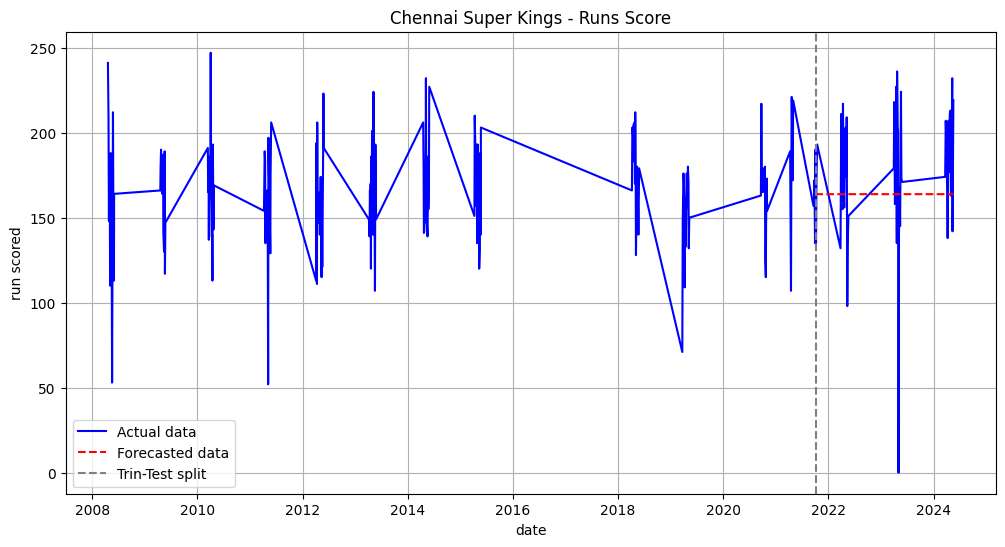

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(time_series_diff , label ="Actual data" , color ="blue")
plt.plot(forecast ,label ="Forecasted data" , color="red", linestyle ="--")
plt.axvline(x =test.index[0], color="gray", linestyle = "--",label = "Trin-Test split")
plt.title(f"{team_name} - Runs Score")
plt.xlabel("date")
plt.ylabel("run scored")
plt.legend()
plt.grid()
plt.show()


In [ ]:
bowler_performance = (
    deliveries.groupby(['match_id', 'bowler'], as_index=False)
    .agg(
        total_wickets=('is_wicket', 'sum'),
        total_runs=('total_runs', 'sum')
    )
)

# Display aggregated data
bowler_performance.head()

NameError: name 'deliveries' is not defined